# Binomial model 01

##### Josep Fortiana 2018-10-17

This session is devoted to three case studies illustrating how a Bayesian perspective enhances the statistical treatment of real-world problems. The first two examples are adapted from the web course by [Charles J. Dimaggio](http://www.columbia.edu/~cjd11/charles_dimaggio/DIRE/styled-4/styled-11/code-4/). The third one is a classical problem from the book by Andrew Gelman and others, _Bayesian Data Analysis - Third edition_ **(BDA3).**

## Case study 1: Perchlorate and Thyroid Tumors

Data for this example come from an online presentation by David Dunson at the US National Institute for Environmental Health Sciences. 

Percholorate is a ground water contaminant that has been associated with thyroid tumors. In a study, 2 of 30 lab rats exposed to perchlorate developed thyroid tumors, compared to 0 of 30 control rats. What conclusions can be drawn?
Given the small numbers, there are difficulties in the classical framework, for instance,  because of the zero value a confidence interval collapses to infinity. What can we learn from a Bayesian approach? 

Clearly for each group, **Exposed** and **Control** rats, the likelihood (for the observed variable, the number of rats developing a tumor) is Binomial and we want to learn about possible different properties (i.e. probability distribution) of the probability parameter in both groups.

In a first run we take a $\mbox{Unif}(0,1)=\mbox{Beta}(1,1)$ prior as a NIP. 

[1] 0.8805

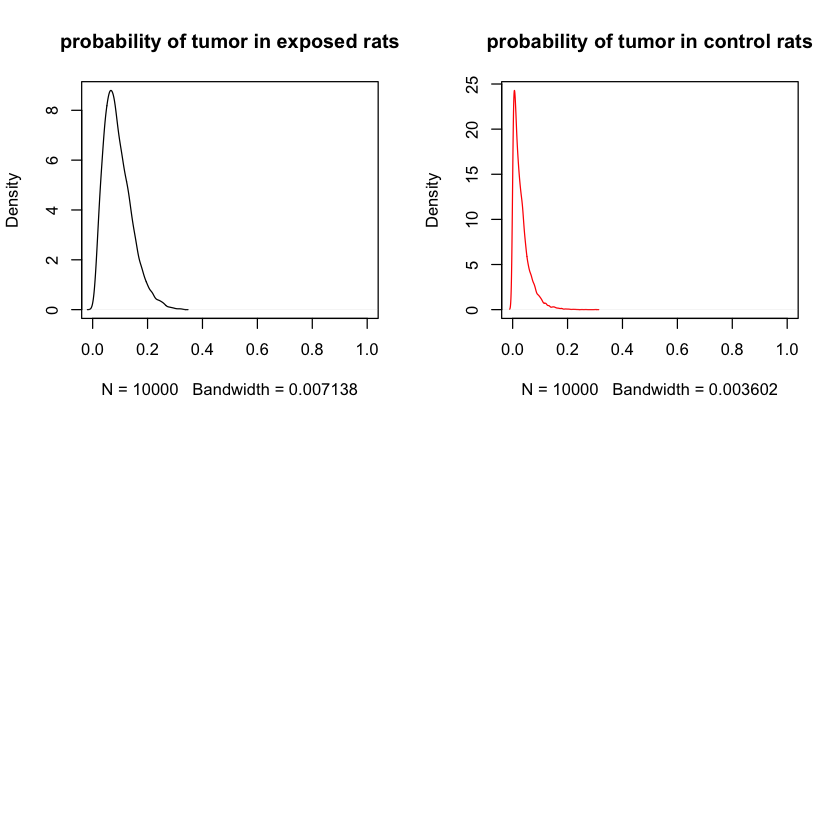

In [5]:
# data
y.perchlorate <- 2; n.perchlorate <- 30
y.control <- 0; n.control<- 30
 
# update Beta(1,1) prior for exposed and unexposed
N<-10000  # sample size for simulations
theta.perchlorate <- rbeta(N,y.perchlorate+1,n.perchlorate-y.perchlorate+1)
theta.control <- rbeta(N,y.control+1,n.control-y.control+1)

# graphically compare exposed and unexposed
old.par<-par(mfrow=c(2,2))
plot(density(theta.perchlorate), xlim=c(0,1), main="probability of tumor in exposed rats")
plot(density(theta.control),  col="red", xlim=c(0,1), main="probability of tumor in control rats")
par(old.par)

# probability that exposed have more tumors than unexposed
sum(theta.perchlorate >= theta.control)/N

A 90% credible interval for the difference of probabilities and an estimation of the pdf of this difference. The interval includes zero, so it is consistent with the non-significance of the difference (from Fisher’s exact test, see reference). But the majority of the probability lies above zero. 

5%         95% 
-0.02793318  0.16342827

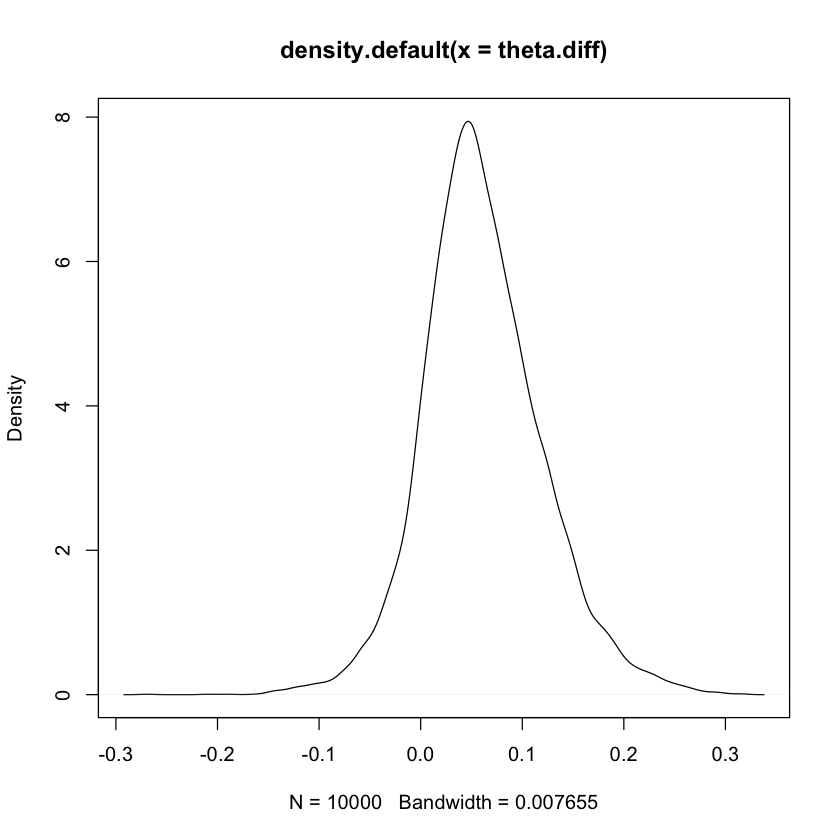

In [6]:
theta.diff<-theta.perchlorate-theta.control

# 90% credible interval
quantile(theta.diff, probs=c(0.05,0.95))

# plot differences
plot(density(theta.diff))

If we have some real prior evidence or belief about the putative association of perchlorate and thyroid tumors. It would be reasonable to assume that we do. Why else would we be doing this experiment in the first place? Dr. Dunson, in his presentation, suggests a $\mbox{Beta}(0.11, 2.6)$ as representing previous experimental evidence. Let’s use that prior, and combine it with our data to update the posterior.

In [7]:
theta.perchlorate <- rbeta(N,y.perchlorate+0.11,n.perchlorate-y.perchlorate+2.6)
theta.control <- rbeta(N,y.control+.11,n.control-y.control+2.6)
theta.diff<-theta.perchlorate-theta.control
quantile(theta.diff, probs=c(0.05,0.95))

5%         95% 
0.008233672 0.142876760

## Case study 2: Drug response

We are interested in the response of patients to a drug. We believe a proportion somewhere between 0.2 and 0.6 of patients will respond, with a mean of 0.4 and a standard deviation of 0.1. In a study of 20 persons, what is the probability that 15 or more will respond? Again, the problem involves a Bernoulli (or Binomial) likelihood. 

We will use a Beta prior (this is the easy path, see below more involved possibilities). To translate the prior information $\mu=0.4$, $\sigma=0.1$ into parameters of a $\mbox{Beta}(\alpha,\beta)$, we must isolate $\alpha$, $\beta$ from the formulas for the moments of a Beta distribution:

$$\begin{aligned}
    \mu         &=\dfrac{\alpha}{\alpha+\beta},\\[0.4cm]
    \sigma^{2}  &=\dfrac{\alpha\,\beta}{(\alpha+\beta)^{2}\,(\alpha+\beta+1)}.\end{aligned}
$$

The result is:

$$\begin{aligned}
    \alpha  &=\mu\cdot\left[\dfrac{\mu\,(1-\mu)}{\sigma^{2}}-1\right],\\[0.4cm]
    \beta   &=(1-\mu)\cdot\left[\dfrac{\mu\,(1-\mu)}{\sigma^{2}}-1\right].\end{aligned}
$$

In our case: $\alpha=9.2$, $\beta=13.8$.

In [2]:
# For a Beta(a,b) distribution, the mean and variance are
# mu<-a/(a+b)
# sigma2<-ab/((a+b)^2*(a+b+1))
# 
# Solving a,b in terms of mu, sigma2
# 
mu<-0.4
sigma<-0.1
sigma2<-sigma^2
G<-(mu*(1-mu))/sigma2-1
a<-mu*G
b<-(1-mu)*G
# 
a; b

[1] 9.2

[1] 13.8

The question we are asked, the probability that 15 or more patients will respond, is previous to any experimental evidence, hence we will get the answer from the **prior predictive distribution**  of the number $X$ of patients responding to treatment out of the $n=20$ patients participating in the study, using only prior information. 

From last session we know that this r.v. follows a $\mbox{Beta-Binomial}(20,9.2,13.8)$ distribution. Thus, in principle we could use this distribution, which can be found in the `extraDistr` package. Thus we can plot the pmf and compute the exact probability we are asked:

Loading required package: extraDistr


[1] 0.015

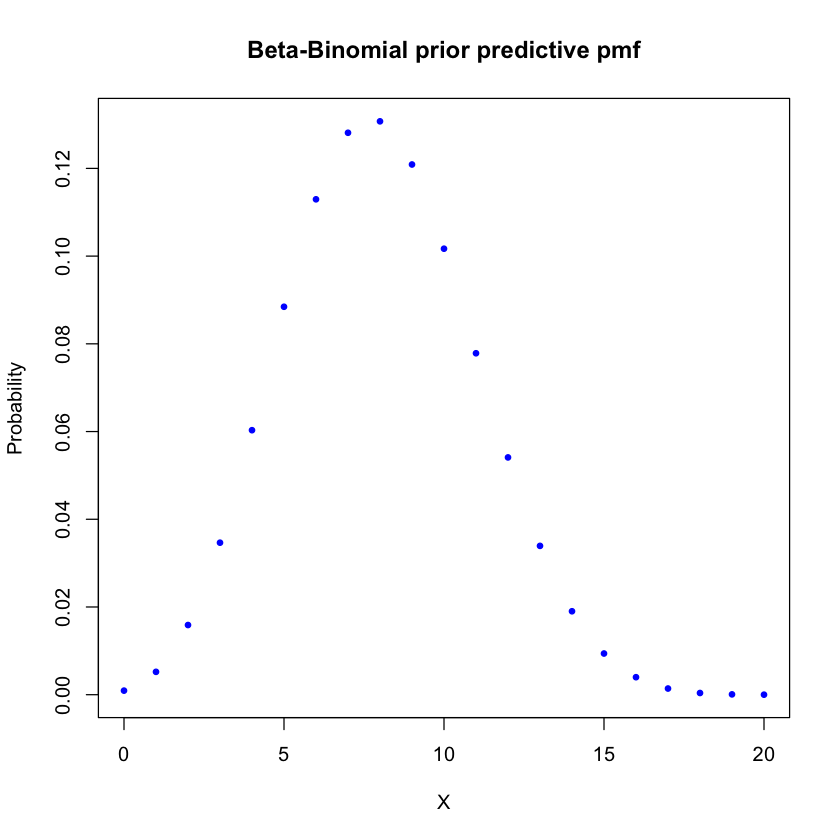

In [3]:
#install.package("extraDistr") 
require(extraDistr)
X<-0:20
plot(X,dbbinom(X, size=20, alpha = 9.2, beta = 13.8),pch=19,cex=0.6,col="blue"
                 ,main="Beta-Binomial prior predictive pmf",ylab="Probability")
P15.exact<-1-pbbinom(14, size=20, alpha = 9.2, beta = 13.8)
round(P15.exact,3)

An alternative approach, both more general in scope (only rarely will we know an explicit pdf for the prior predictive) and more according to a computational statistics mindset is to sample from this distribution by simulation and infer the desired properties from the resulting sample.

We generate a number $N$  of realizations of the experiment. In each one of them $\theta$ is generated from a
$\mbox{Beta}(\alpha,\beta)=\mbox{Beta}(9.2,13.8)$, then $x$ is generated from a $\mbox{B}(20,\theta)$. Note the way in which syntax takes advantage of the vectorized `theta` parameter in `rbinom()`. In the empirical pmf I use a clumsy piece of code as `table()` does not contemplate zero counts:

[1] 0.0184

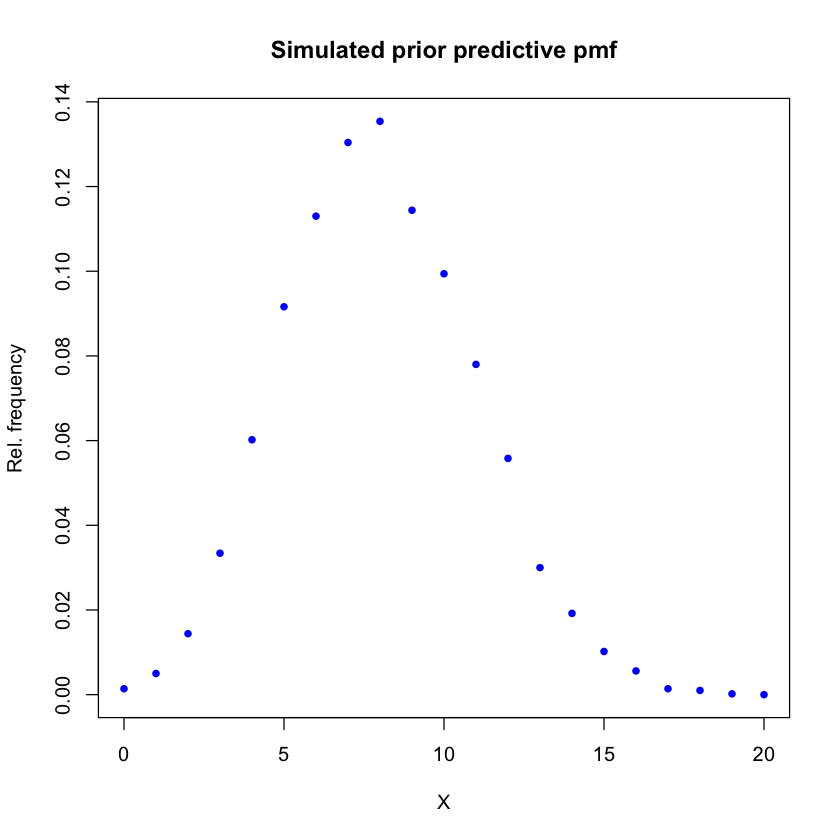

In [11]:
N<-5000
n<-20
n1<-15
theta<-rbeta(N,a,b)
x<-rbinom(N,n, theta)
accept<-(x>=n1)*1
(prob<-sum(accept)/N)
F<-rep(0,length(X))
for (i in X){
    F[i]<-sum(x==X[i])
    }
f<-F/N
plot(X,f,,pch=19,cex=0.7,col="blue",main="Simulated prior predictive pmf",ylab="Rel. frequency")

Now assume we have made an experiment with $n=20$ patients and we observe that actually $x=15$ of them respond to the drug treatment. The posterior $\theta$ distribution, including this evidence, is:

$$
    \mbox{Beta}(\alpha+x,\beta+n-x)=\mbox{Beta}(9.2+15,13.8+20-15)=\mbox{Beta}(24.2,18.8),
$$

which has $\mu=0.56$, $\sigma=0.075$, a larger mean than our prior (consistent with the large observed number) and a smaller standard deviation (reflecting that we have increased information about the experiment).

### Exercise

Now consider further experimentation with this drug, after this first result. We test it with 40 new patients, being aware that funding will continue if we observe 25 or more successes in this trial. What is the probability of this result?

In [23]:
N<-5000
theta<-rbeta(N,24.2,18.8)
x<-rbinom(N,40,theta)
accept<-(x>=25)*1
prob<-sum(accept)/N
prob

[1] 0.3268

## Case study 3: Placenta previa

Placenta previa is a problem in pregnancy where the placenta implants low on the uterus, potentially obstructing the birth canal. The data involve the proportion of births with placenta previa that are female gender. The question is whether placenta previa influences birth gender. We know that: 

1. The proportion of female births in this population is 48.5\%. 

2. A study of 980 placenta previa births found that 437 (44.6\%) of them were female. 
	
How much evidence does this provide for the claim that the proportion of female births is less than 0.485?

### _Analysis using a nonconjugate prior distribution (a) A discrete prior_

In the BDA3 book they consider conjugate (Beta) priors, just as in the above two Case Studies, which you can follow as a (highly recommended) exercise. Here, instead, we will use their next suggestion, a nonconjugate prior. 

As a first stage, as a sort of springboard, we take a very simple, discrete prior. To this end we add a fictitious historical proportion (from another state, say) of 45.0%. We assume a priori that both historical figures are equally probable.

Thus, our discrete prior is:

$$
	\begin{array}{lcl}
	\theta_{1}=0.485	&\text{ with probability }	&\pi_{1}\equiv P(\theta_{1})=0.5,\\
	\theta_{2}=0.45		&\text{ with probability }	&\pi_{2}\equiv P(\theta_{2})=0.5.
	\end{array}
$$

Likelihood is the usual binomial one:

$$
    f(x|\theta)=\theta^{x}\cdot(1-\theta)^{(n-x)}.
$$

In actual computations it may be safer to use its logarithm, _Log-likelihood,_ to avoid products of very large and very small quantities.

In [2]:
# Prior information
theta.1<-0.485
theta.2<-0.45
Prior.1<-0.5
Prior.2<-0.5
LogPrior.1<-log(Prior.1)
LogPrior.2<-log(Prior.2)
# Observed data
n<-980
x<-437
theta.obs<-x/n
round(theta.obs,3)

[1] 0.446

Likelihood, joint pdf and their logarithms. Bayes formula needs the x marginal in the denominator to give the posterior pdf, but we can circumvent this step by normalizing to one the _non-normalized_ posterior pdf. Observe that, consistently with the data, the posterior probability of 0.45 is much higher than its prior value:

In [3]:
Lik<-function(x,theta,n){theta^x*(1-theta)^(n-x)}
LogLik<-function(x,theta,n){x*log(theta)+(n-x)*log(1-theta)}
LogPost.1<-LogLik(x,theta.1,n)+LogPrior.1
LogPost.2<-LogLik(x,theta.2,n)+LogPrior.2
Post.1<-exp(LogPost.1)
Post.2<-exp(LogPost.2)
S<-(Post.1+Post.2)
Post.1<-Post.1/S
Post.2<-Post.2/S
round(Post.1,3)
round(Post.2,3)

[1] 0.049

[1] 0.951

### _Analysis using a nonconjugate prior distribution (b) A triangular pdf_

In the BDA3 book they consider first conjugate (Beta) priors, just the same procedure as in the two previous Case Studies, which you can follow as a (highly recommended) exercise. Here, instead, we will use their next suggestion,
namely the triangular pdf in the figure:

![alt text](Placenta.previa.Nonconjugate.prior.jpg "Triangular prior")

This pdf has the following specifications:

1. It is centered at $m=0.485$ 

2. 40% of the probability mass is outside the interval [m-c,m+c]=[0.385,0.585], c=0.100.

#### Exercise
From the information above, check that the equation of this pdf is:

$$
    h(t)=\left\{
    \begin{array}{lcl}
         a,        &\text{ for }  &0<t<m-c \quad\text{and } m+c<t<1,\\
         A+b\cdot t/c,  &\text{ for }  &t\in [m-c,c],\\ 
         B-b\cdot t/c   &\text{ for }  &t\in [c,m+c],\\ 
    \end{array}
    \right.,\quad t \in[0,1]
$$

where $a=0.50$, $b=5.00$ is the height of the central triangle ($a+b$ is the peak ordinate), $A=a+b-(b\cdot m)/c$,
$B<-a+b+(b\cdot m)/c$.

Write a function `h()`to compute the pdf $h(t)$, plot it (verify that the integral on $[0,1]$ is indeed equal to 1),
compute its expectation and variance.
_Hint: $a$ is determined by the equation $0.40=p_{tails} = a\cdot(1-2\cdot c)$, then the area of the upper central isosceles triangle is $c\cdot b = 1-a =0.5$._

![alt text](Placenta.previa.Nonconjugate.prior.1.jpg "Triangular prior (R plot)")

In [101]:
h<-function(t){
    
    m<-0.485
    c<-0.100
    p.tails<-0.4  
    a<-0.5
    b<-5.0
    A<-a+b-(b*m)/c
    B<-b+a+(b*m)/c
    
    if ((0<=t && t<m-c) || (m+c<t && t<=1)) {
        return(a)
    } else if (m-c<=t && t<=m) {
        return(A+b*t/c)
    } else if (m<=t && t<=m+c) {
        return(B-b*t/c)
    }
    return(0)
    
}

#### Discretizing the continuous prior

Next we construct a grid of $N$ points $\mathbf{t}=(t_1,\dots,t_{N-1})$ on the $[0,1]$. On each interval $[t_{i},t_{i+1}$, $1\leq i\leq N-1$, the probability from the prior pdf, the integral of $h(t)$ on it, is approximated by the rectangle area $h(t_i)\cdot\delta$, where $\delta=1/N$. The discrete r.v. defined by both vectors: values $\mathbf{t}$ and probabilities $h(\mathbf{t})\cdot \delta$ is a _discretization_ of the continuous r.v. with pdf $h$, a reasonable approximation by a discrete distribution of the given continuous probability distribution. We proceed with this discrete r.v. as in the example above.

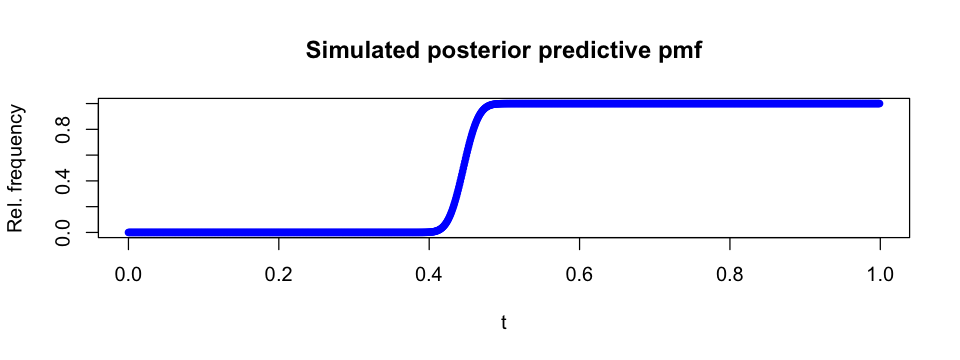

In [102]:
n<-980
x<-437
N<-1000 # number of grid intervals
t<-seq(0,1,length=N)
t<-t[-N]# remove last point (equal to 1: we want N intervals)
#
# Lik and LogLik are the Bernoulli quantities defined above
# uncomment only one of the following three lines:
# Use plain likelihood or use logs and, in this case there is the alternative
# to use the dbinom() function (which we expect has been thoughtfully and robustly designed)
#
# nnpost<-Lik(x,t,n)*h(t)
# log.nnpost<-LogLik(x,t,n)+log(h(t))
 log.nnpost<-dbinom(x,size=n,prob=t,log=TRUE)+log(h(t))
#
nnpost<-exp(log.nnpost)
#
# NB. We do not bother to write delta=1/N in the probability values h(t)*delta. Furthermore,
# dbinom() is a multiple of Lik (times the combinatorial coefficient). All these constants
# will be taken care of when normalizing.
#
# Then these non normalized values, after normalized to unit sum, will be the pmf of a discretization of
# the posterior distribution.
#
dpost<-nnpost/sum(nnpost) # pmf
ppost<-c(0,cumsum(dpost)) # cdf
discretetization_sampling <- sample(t, size = N, replace = TRUE, prob = nnpost)
pr_pred<-rbinom(N, n, discretetization_sampling)

#hist(discretetization_sampling,main="Sampling from the discretization",nclass = 100)
plot(t,ppost[2:N],,pch=19,cex=0.7,col="blue",main="Simulated posterior predictive pmf",ylab="Rel. frequency")

From this pmf/cdf for a discretization of the posterior pdf we can obtain any needed posterior quantity: popsterior quantiles, in particular the posterior median, a 95% credible interval, the MAP and posterior expectation estimators of $\theta$, etc.

# Homework

## Exercise 3 - Further computations with the placenta previa exercise

(See exercises 1 and 2 in the assignment sheet)

### 3.1

Compute the posterior pdf, and both prior and posterior predictor pmf for the placenta previa problem, using a conjugate $\mbox{Beta}(\alpha,\beta)$ prior, for several values of the parameters, obtaining for each of them a 95% (centered) credible interval and the MAP and posterior expectation estimators of $\theta$. In particular, reproduce Figure 2.3 and Table 2.1 in BDA3. Do the same for those $\alpha_0$ and $\beta_0$ such that $\mbox{Beta}(\alpha_0,\beta_0)$ has the same expectation and variance than the piecewise linear nonconjugate prior. Compare the posterior quantities with both priors. 

In [6]:
# extract values for alpha and beta that correspond to the calculations in table 2.1
library(extraDistr)
table_values1 <- c(0.5, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485, NA)
table_values2 <- c(2, 2, 5, 10, 20, 100, 200, NA)

alphas <- 1:8
betas <- 1:8

for (i in 1:8) {
    alphas[i] <- table_values1[i]*table_values2[i]
    betas[i] <- table_values2[i] - alphas[i]
}




In [22]:
# find a0 and b0 such that the distribution has the same mean and std as the piecewise linear function

# analytically we can find the mean and std for the function
h_m <- 0.493
h_s <- 0.21

# then we simply use the formula as given in case study 2 to get alpha and beta from these
h_s2<-h_s^2
G<-(h_m*(1-h_m))/h_s2-1
alpha0<-h_m*G
beta0<-(1-h_m)*G

# add these values to the list that we are going to evaluate
alphas[8] <- alpha0
betas[8] <- beta0
table_values1 <- alphas /(alphas + betas)
table_values2 <- alphas + betas

In [8]:
mode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

N<-1000
n<-980
n1<-437

post_pred_median <- rep(0,8)
E <- rep(0,8)
Q_lower <- rep(0,8)
Q_upper <- rep(0,8)
MAP <- rep(0,8)

for (i in 1:8) {
    
    a = alphas[i]
    b = betas[i]
    
    # posterior - beta with a+n1, b+n-n1
    posterior <- rbeta(N,a+n1,b+n-n1)

    # prior predictor - beta-binomial with a,b
    prior_predictor <- rbbinom(N, n, a, b)

    # posterior predictor - beta-binomial with a+n1,b+n-n1
    posterior_predictor <- rbbinom(N, n, a+n1, b+n-n1)
    
    # posterior expectation of theta - we can check the formula from the lectures
    # against what the data shows to confirm, and indeed they are the same
    # (with some rounding error)
    m <- median(sort(posterior))
    e <- (a+n1)/(a+b+n)
    
    # 95% credible interval
    q <- quantile(posterior, probs=c(0.025,0.975))
    
    # MAP for theta, which is essentialy the mode of the posterior
    map <- mode(round(posterior,3))
    
    # save these so we can create the table
    post_pred_median[i] <- m
    E[i] <- e
    Q_lower[i] <- q[1]
    Q_upper[i] <- q[2]
    MAP[i] <- map
    

    
}


#CREATING THE TABLE 2.1
table_2_1 <- data.frame(alphas = round(alphas,2), betas = round(betas,2), p = table_values1, t = table_values2, 
                        E = round(E,3) , Q_lower = round(Q_lower,3), 
                       Q_upper = round(Q_upper,3), MAP = round(MAP,3))
table_2_1 <-  dplyr::rename(table_2_1,'$\\frac{\\alpha}{\\alpha + \\beta}$' = p,
                         '$\\alpha+\\beta$' = t,
                         'Posterior  median of $\\theta$' = E,
                          'Lower bound of 95% interval' = Q_lower,
                        'Upper bound of 95% interval' = Q_upper,
                           '$\\alpha$' = alphas,
                           '$\\beta$' = betas)

for (i in 1:nrow(table_2_1)){
    table_2_1$'95% posterior interval for $\\theta$' [i] <- paste('[', paste(toString(table_2_1$'Lower bound of 95% interval'[i]),
                               toString(table_2_1$'Upper bound of 95% interval'[i]),sep = ", "),
                               ']', sep = "")
}

table_2_1$'Lower bound of 95% interval' <- NULL
table_2_1$'Upper bound of 95% interval' <- NULL

table_2_1 <- table_2_1[,c(1,2,3,4,5,7,6)]
table_2_1



$\alpha$,$\beta$,$\frac{\alpha}{\alpha + \beta}$,$\alpha+\beta$,Posterior median of $\theta$,95% posterior interval for $\theta$,MAP
1.00,1.00,0.500,2.000000,0.446,"[0.417, 0.479]",0.451
0.97,1.03,0.485,2.000000,0.446,"[0.414, 0.475]",0.442
2.42,2.58,0.485,5.000000,0.446,"[0.415, 0.475]",0.441
4.85,5.15,0.485,10.000000,0.446,"[0.416, 0.478]",0.444
9.70,10.30,0.485,20.000000,0.447,"[0.417, 0.478]",0.446
48.50,51.50,0.485,100.000000,0.450,"[0.419, 0.479]",0.451
97.00,103.00,0.485,200.000000,0.453,"[0.425, 0.481]",0.452
2.30,2.37,0.493,4.667823,0.446,"[0.416, 0.476]",0.441


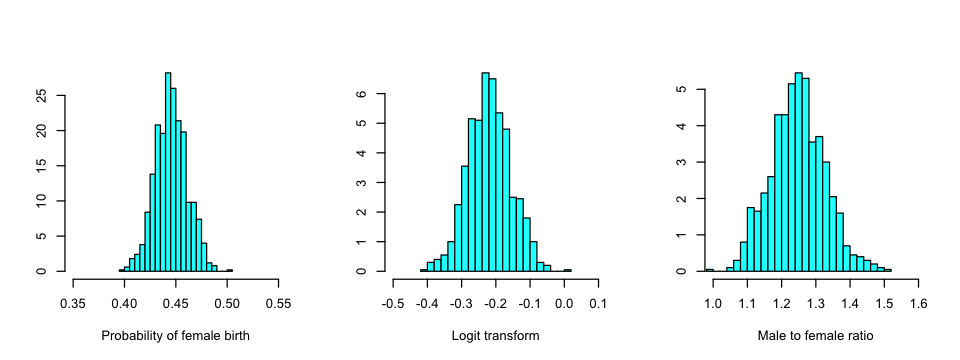

In [5]:
library(MASS)

logit <- function(p){log(p/(1-p))}
ratio <- function(p){(1-p)/p}

options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))

truehist(posterior, xlim=c(0.35,0.55), xlab = "Probability of female birth")
truehist(logit(posterior), xlim=c(-0.5,0.1), xlab = "Logit transform")
truehist(ratio(posterior), xlim=c(1,1.6), xlab = "Male to female ratio")

### 3.2

Simulate the prior predictive pmf with the nonconjugate piecewise linear pdf. Do it in both possible ways: (1) Sample from $h$ by the inverse transformation method and (2) Sample from its discretization. 

Summarize the resulting simulated sample: plot the empirical pmf, compute median, mode, expectation, standard deviation. Compare the results with those obtained from the conjugate prior $\mbox{Beta}(\alpha_0,\beta_0)$. 

Warning message in sqrt(100 * u - 19):
“production de NaN”Warning message in sqrt(159 - 200 * u):
“production de NaN”

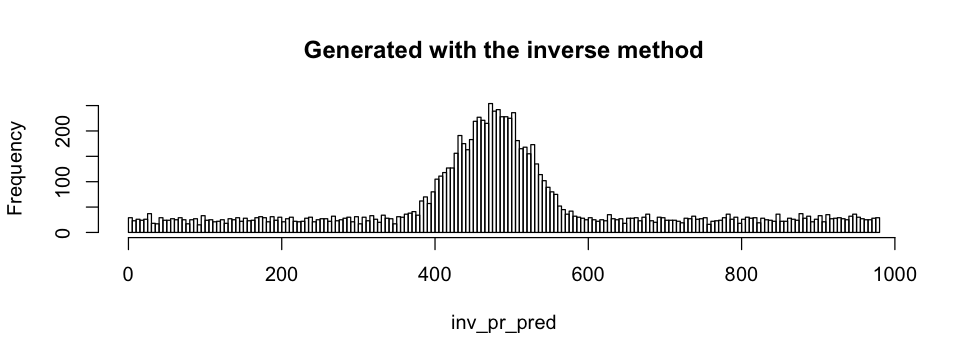

In [10]:
inv<-function(n){
    u<-runif(n)
    l<-ifelse( u<0.1925, 2*u, 
               ifelse( u<0.4925, 0.375 + 0.02*sqrt(100*u-19), 
                       ifelse( u<0.7925, 0.595 - 0.0141421*sqrt(159-200*u), 2*u-1 )))
    return(l)
}

N = 10000
u<-seq(0,1,length=N)
inv_pr_pred<-rbinom(N, n, inv(u))
hist(inv_pr_pred,main="Generated with the inverse method",nclass = 200)

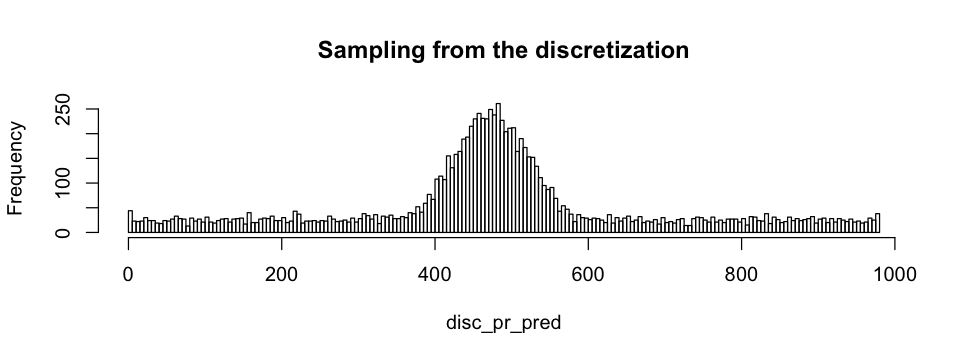

In [13]:
h<-function(t){
    
    m<-0.485
    c<-0.100
    p.tails<-0.4  
    a<-0.5
    b<-5.0
    A<-a+b-(b*m)/c
    B<-b+a+(b*m)/c
    
    if ((0<=t && t<m-c) || (m+c<t && t<=1)) {
        return(a)
    } else if (m-c<=t && t<=m) {
        return(A+b*t/c)
    } else if (m<=t && t<=m+c) {
        return(B-b*t/c)
    }
    return(0)
    
}


t<-seq(0,1,length=N)
t<-t[-N]
probs<-lapply(t,function(x){h(x)/N})
discretetization_sampling <- sample(t, size = N, replace = TRUE, prob = probs)
disc_pr_pred <- rbinom(N, n, discretetization_sampling)
hist(disc_pr_pred,main="Sampling from the discretization",nclass = 200)

In [15]:
message("From the inverse transformation we obtain the median: ", round(median(inv_pr_pred),1))
message("From the inverse transformation we obtain the mode: ", round(mode(inv_pr_pred),1))
message("From the inverse transformation we obtain the expectation: ", round(mean(inv_pr_pred),1))
message("From the inverse transformation we obtain the standard deviation: ", round(sd(inv_pr_pred),1),"\n")

message("From the discretization we obtain the median: ", round(median(disc_pr_pred),1))
message("From the discretization we obtain the mode: ", round(mode(disc_pr_pred),1))
message("From the discretization we obtain the expectation: ", round(mean(disc_pr_pred),1))
message("From the discretization we obtain the standard deviation: ", round(sd(disc_pr_pred),1),"\n")

From the inverse transformation we obtain the median: 479
From the inverse transformation we obtain the mode: 503
From the inverse transformation we obtain the expectation: 486.9
From the inverse transformation we obtain the standard deviation: 205.3

From the discretization we obtain the median: 475
From the discretization we obtain the mode: 483
From the discretization we obtain the expectation: 481
From the discretization we obtain the standard deviation: 202.5



The values from $Beta(\alpha_{0},\beta_{0})$ were:

In [25]:
conjugate_prior <- rbbinom(N, n, alpha0, beta0)

message("Expected value of Beta(alpha_0, beta_0) = ", round(mean(conjugate_prior), 1))
message("Standard deviation of Beta(alpha_0, beta_0) = ", round(sd(conjugate_prior), 1))

Expected value of Beta(alpha_0, beta_0) = 483.5
Standard deviation of Beta(alpha_0, beta_0) = 206.5


### 3.3

Simulate the posterior predictive pmf (given the observed data of 437 female births from 980 placenta previa births) with the nonconjugate piecewise linear pdf. Sample from the the discretization of the posterior pdf as in Exercise 2.

Summarize the resulting simulated sample: plot the empirical pmf, compute median, mode, expectation, standard deviation. Compare the results with those obtained from the conjugate prior $\mbox{Beta}(\alpha_0,\beta_0)$.

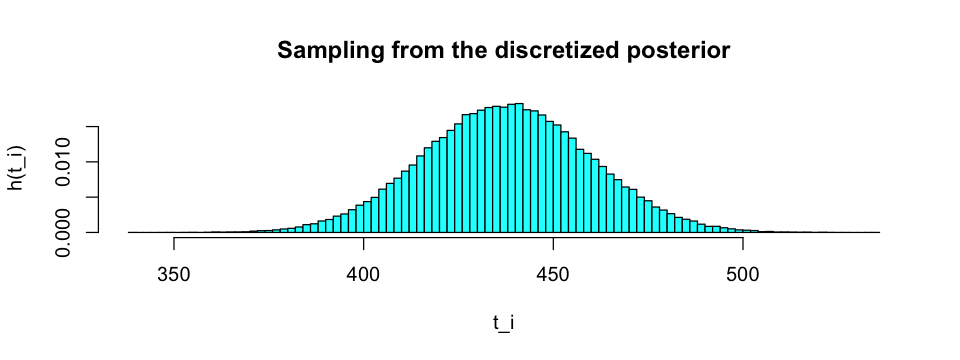

In [21]:
n<-980
x<-437
N1<-1000
t<-seq(0,1,length=N)
t<-t[-N]
N = 100000

Likelihood <- function(x,theta,n){theta^x*(1-theta)^(n-x)}
nnpost <- Likelihood(x,t,n)*h(t)
dpost<-nnpost/sum(nnpost)
probs <- 1/N1*dpost
discrete_posterior = sample(t, size = N, replace = TRUE, prob = probs)
discrete_post_predictive<-rbinom(N, n, discrete_posterior)

truehist(discrete_post_predictive, xlab = "t_i", ylab = "h(t_i)",
         main = "Sampling from the discretized posterior")

In [19]:
message("From the discretization we obtain the median: ", round(median(discrete_post_predictive),3))
message("From the discretization we obtain the mode: ", round(mode(discrete_post_predictive),3))
message("From the discretization we obtain the expectation: ", round(mean(discrete_post_predictive),3))
message("From the discretization we obtain the standard deviation: ", round(sd(discrete_post_predictive),3),"\n")


From the discretization we obtain the median: 437
From the discretization we obtain the mode: 438
From the discretization we obtain the expectation: 437.013
From the discretization we obtain the standard deviation: 22.075



In [26]:
conjugate_posterior <- rbbinom(N, n, alpha0 + x, beta0 + n - x)
message("Expected value of Beta(alpha_0, beta_0) = ", round(mean(conjugate_posterior), 1))
message("Standard deviation of Beta(alpha_0, beta_0) = ", round(sd(conjugate_posterior), 1))

Expected value of Beta(alpha_0, beta_0) = 437.2
Standard deviation of Beta(alpha_0, beta_0) = 22
